In [ ]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple

from labelmaker.consensus import VALID_LABEL_SPACES
from labelmaker.label_data import get_nyu40, get_scannet200, get_wordnet, get_ade150


In [ ]:
SCENE_ID=47333462
# WORKSPACE_DIR = f'/home/weders/scratch/scratch/LabelMaker/arkitscenes/{SCENE_ID}'
WORKSPACE_DIR = '/scratch/quanta/Experiments/LabelMaker/arkit_test_scene'


In [ ]:
# load all model folders
model_folders = [
    x for x in os.listdir(os.path.join(WORKSPACE_DIR, 'intermediate'))
    if x.split('_')[0] in VALID_LABEL_SPACES and x.split('_')[-1] != "lifted"
]
if 'consensus' in os.listdir(os.path.join(WORKSPACE_DIR, 'intermediate')):
  model_folders.append('consensus')

if 'wordnet_3d_lifted' in os.listdir(os.path.join(WORKSPACE_DIR,
                                                  'intermediate')):
  model_folders.append('wordnet_3d_lifted')


In [ ]:
print(model_folders)


['wordnet_groundedsam_1', 'nyu40_cmx_1', 'ade20k_internimage_1', 'scannet200_mask3d_1', 'wordnet_ovseg_1', 'consensus', 'wordnet_3d_lifted']


In [ ]:
# load all images
image_files = sorted([Path(x).stem for x in os.listdir(os.path.join(WORKSPACE_DIR, 'color')) if x.endswith('.jpg')])


In [ ]:
# visalization options
vis_freq = 200


In [ ]:
COLOR_MAPS = {
    'ade20k': get_ade150,
    'scannet200': get_scannet200,
    'nyu40': get_nyu40,
    'wordnet': get_wordnet,
    'consensus': get_wordnet,
    "sdfstudio": get_wordnet,
}


def load_image(path: str) -> np.ndarray:
  """Load an image from the workspace.
    
    Args:
        image_id (str): image id
    
    Returns:
        np.ndarray: image
    """
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


def load_label(path: str) -> np.ndarray:
  """Load a label from the workspace.
    
    Args:
        label_space (str): label space
        image_id (str): image id
    
    Returns:
        np.ndarray: label
    """
  label = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  return label


def colorize_label(label: np.ndarray, label_space: str) -> np.ndarray:
  """Colorize a label image for visualization.
    
    Args:
        label (np.ndarray): label image
    
    Returns:
        np.ndarray: colorized label image
    """

  if label_space not in COLOR_MAPS:
    raise ValueError(f'Invalid label space: {label_space}')

  color_maps = COLOR_MAPS[label_space]()

  label = label.astype(np.uint8)

  label_colorized = np.zeros((label.shape[0], label.shape[1], 3),
                             dtype=np.uint8)

  for ui in np.unique(label):
    label_colorized[label == ui] = color_maps[ui]['color']

  return label_colorized


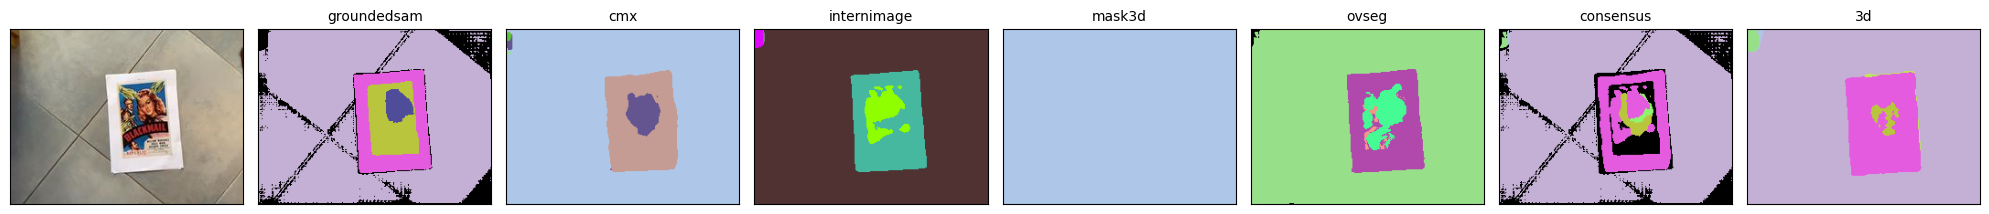

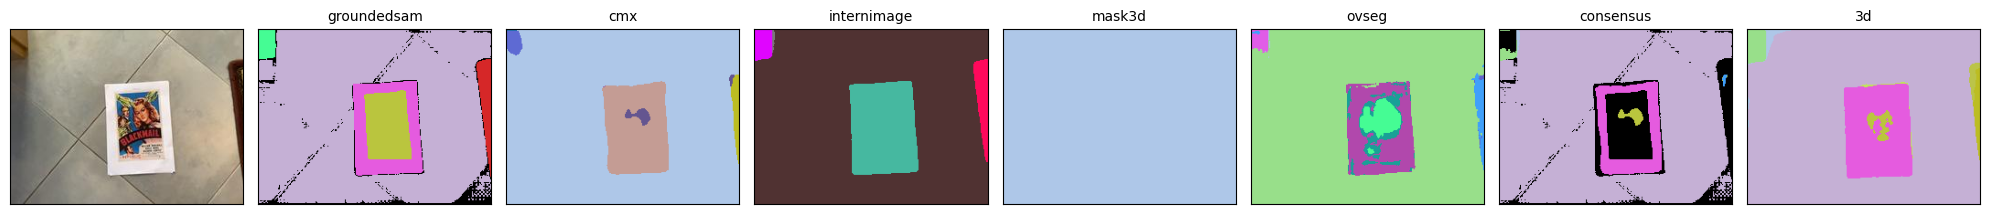

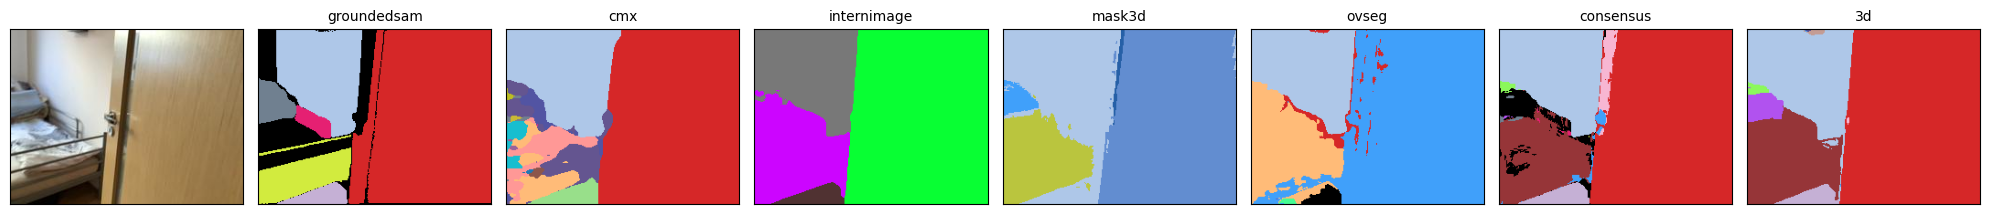

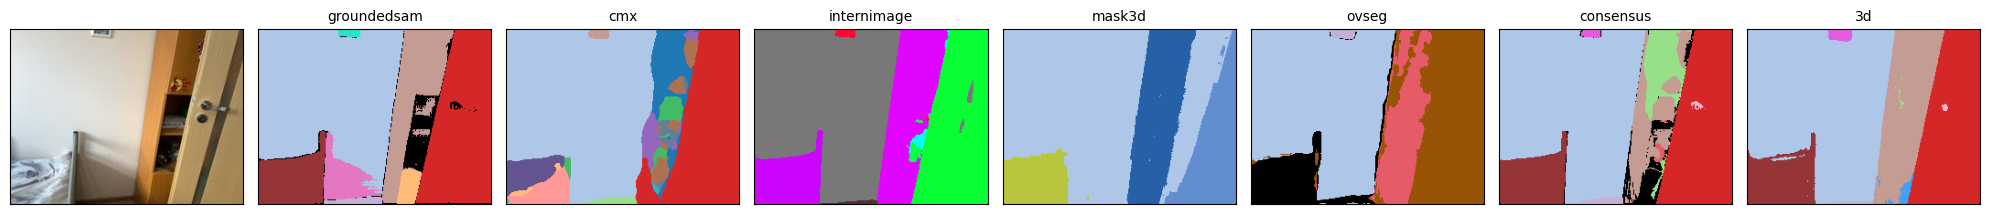

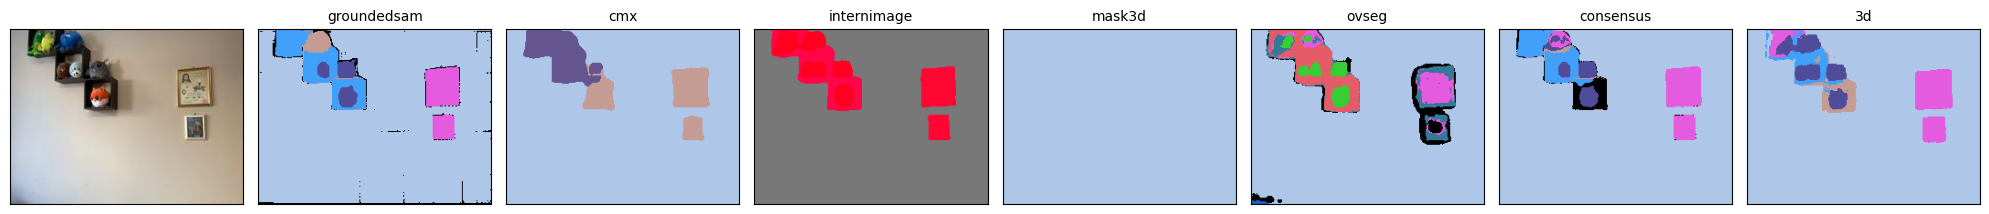

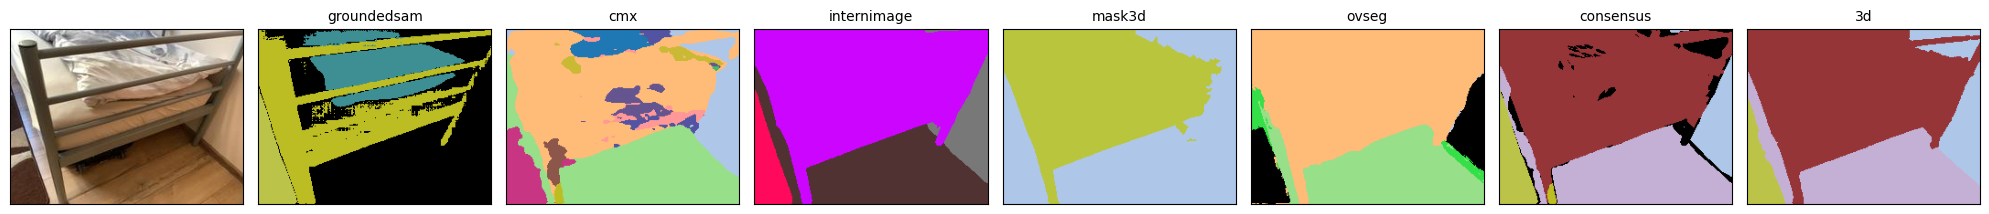

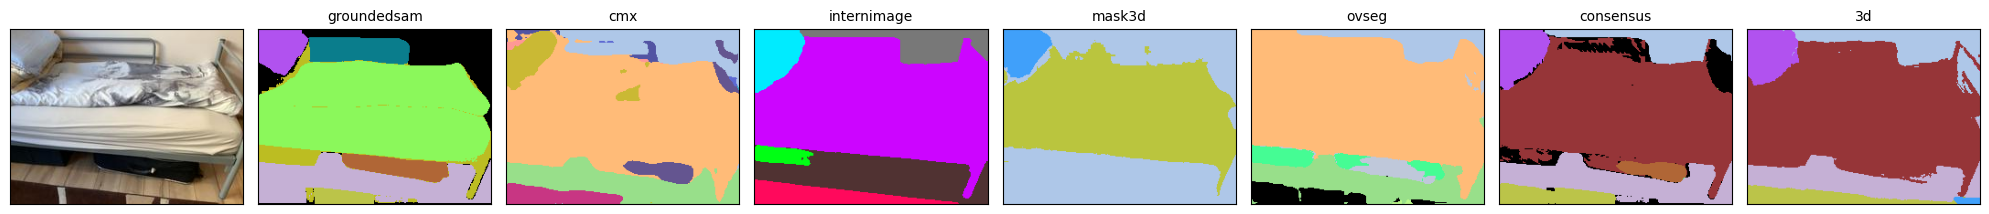

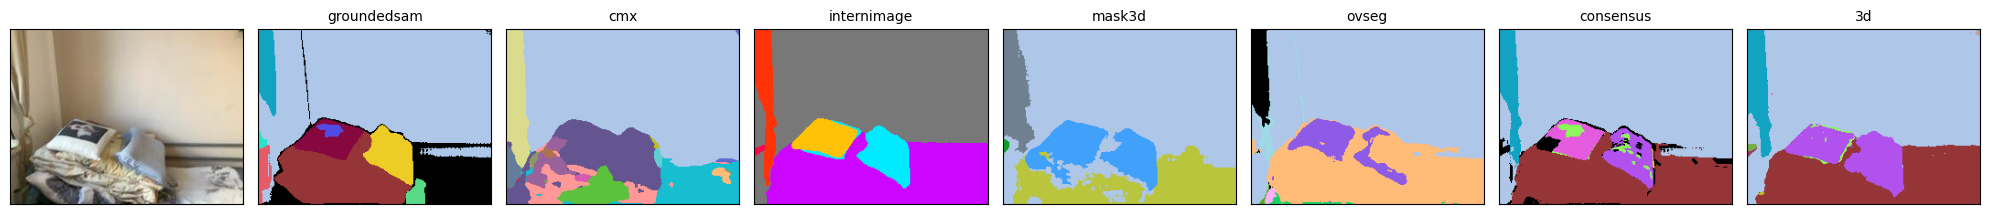

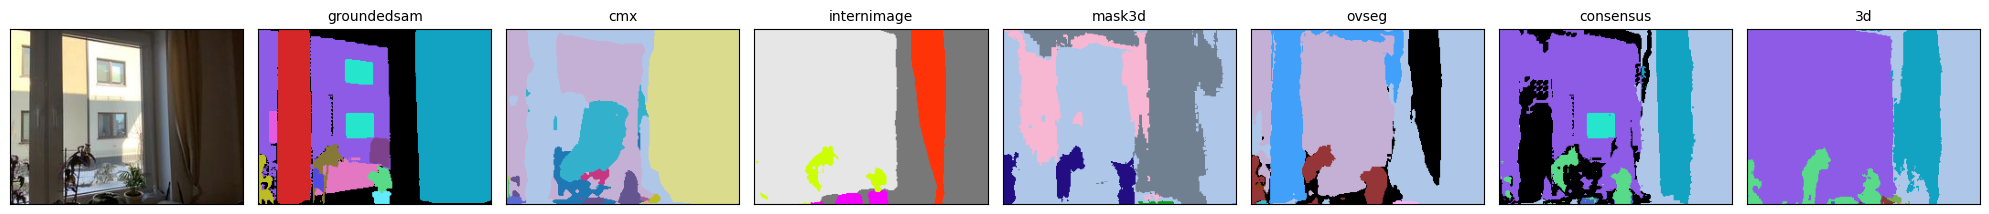

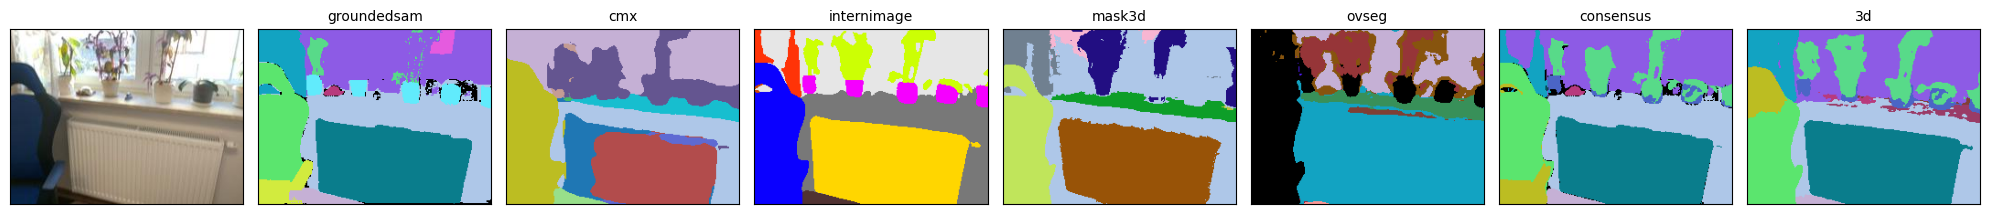

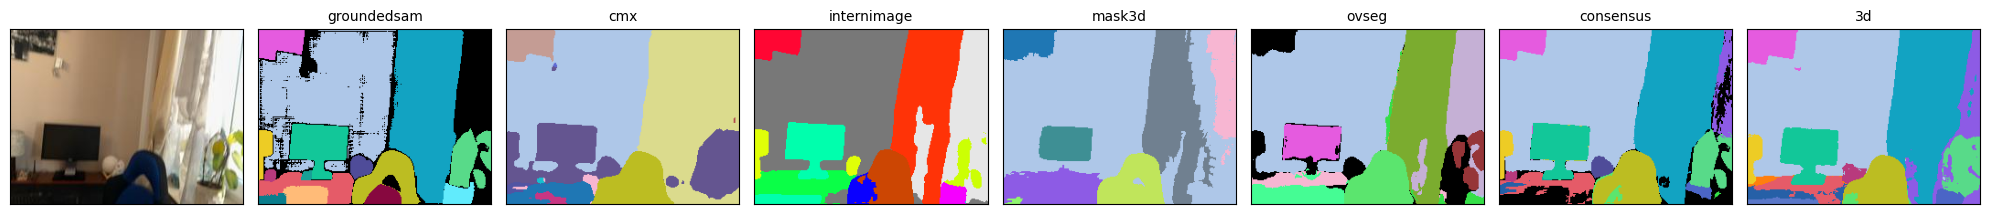

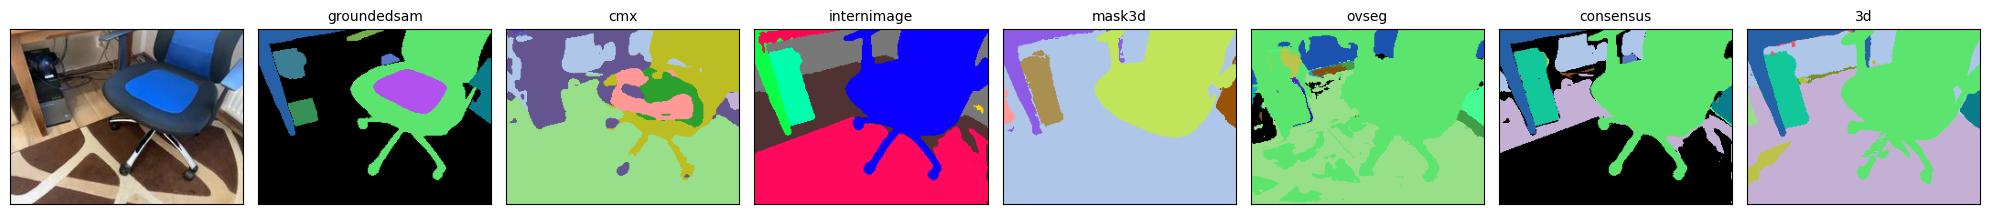

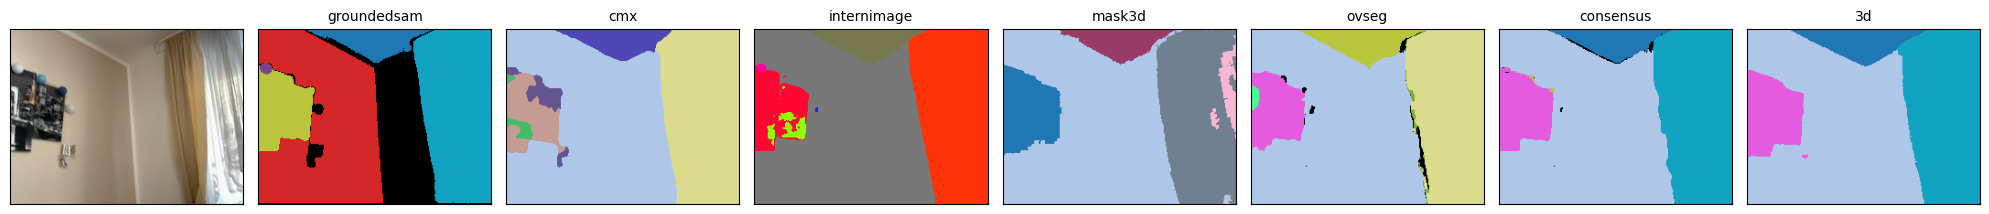

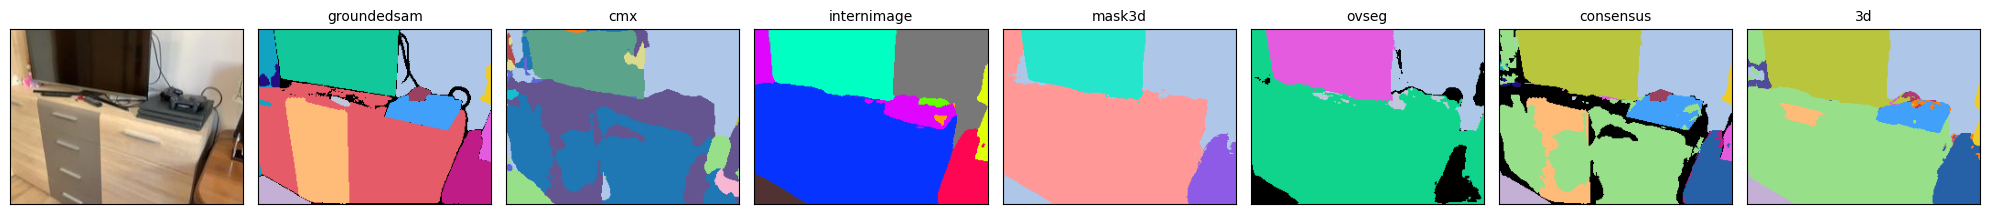

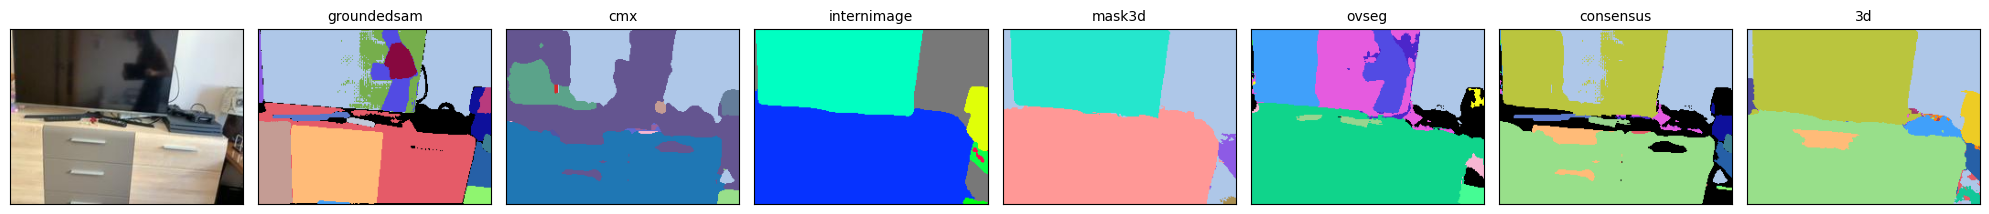

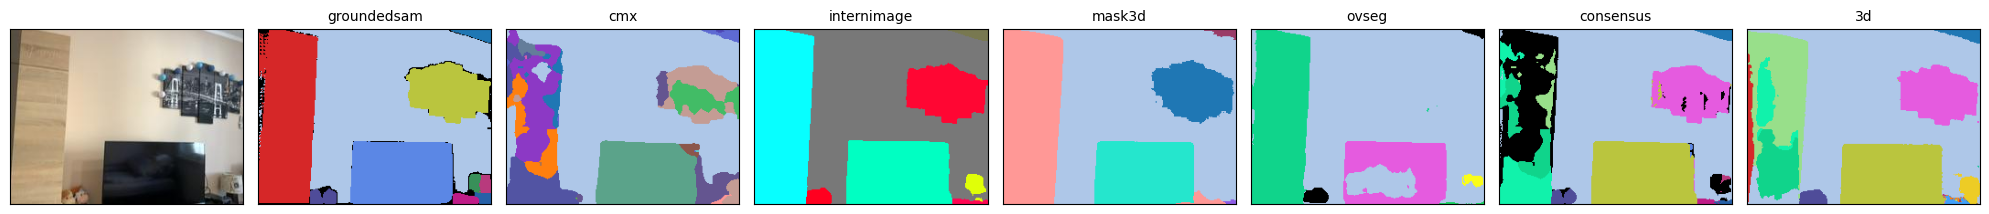

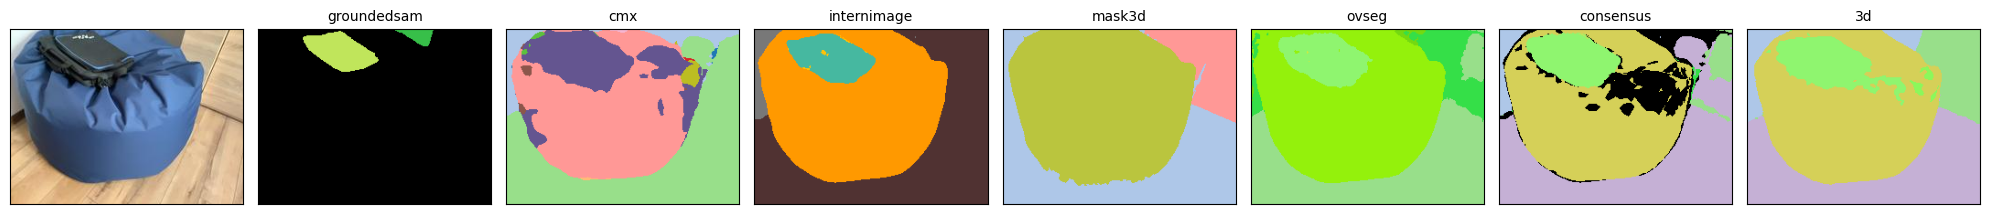

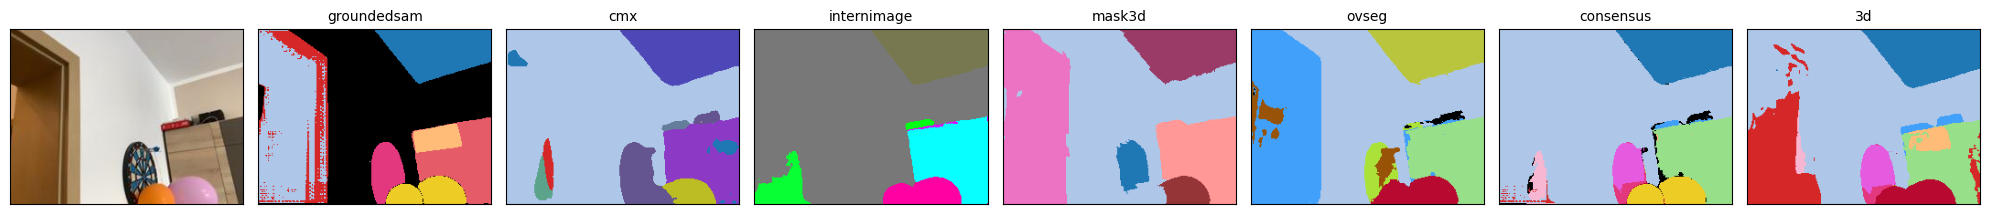

In [ ]:
for idx, f in enumerate(image_files):
  if idx % vis_freq == 0:

    image = load_image(os.path.join(WORKSPACE_DIR, 'color', f'{f}.jpg'))
    label_frames = []
    for model_folder in model_folders:
      if model_folder != "wordnet_3d_lifted":
        label = load_label(
            os.path.join(WORKSPACE_DIR, 'intermediate', model_folder,
                         f'{f}.png'))
      else:
        label = load_label(
            os.path.join(WORKSPACE_DIR, 'intermediate', model_folder,
                         '{:05d}.png'.format(int(f))))

      label = colorize_label(label, model_folder.split('_')[0])
      label_frames.append(label)

    fig, ax = plt.subplots(1, len(label_frames) + 1, figsize=(20, 10))
    ax[0].imshow(image)
    for jdx, label_frame in enumerate(label_frames):
      name = 'consensus' if 'consensus' in model_folders[
          jdx] else model_folders[jdx].split('_')[1]
      ax[jdx + 1].imshow(label_frame)
      ax[jdx + 1].set_title(name, fontsize=10)

    # remove xticks
    for axi in ax:
      axi.set_xticks([])
      axi.set_yticks([])
    plt.tight_layout()
    plt.show()
